# Aerator Imports Analysis (2021-2024) - Modular Architecture

This notebook provides a **clean, modular analysis** of aerator imports data from Peruvian customs records spanning 2021-2024. The analysis includes:

- **Data loading and cleaning** with standardized preprocessing
- **Statistical analysis and summary statistics** with comprehensive metrics
- **Price distribution analysis** with outlier handling
- **Brand comparison** with filtered price ranges
- **Categorical data visualization** with individual plot generation

## 🏗️ Enhanced Modular Architecture

The notebook now uses a **clean, modular approach** where:

- **Class definitions** are moved to `aerator_analysis.py` for reusability
- **Configuration** is centralized in `config.py`
- **Notebook focus** is purely on analysis workflow and visualization
- **Memory efficiency** through individual plot generation
- **Code maintainability** with centralized updates

### 📦 Module Structure:

- `aerator_analysis.py` - Core analysis classes (DataLoader, DataCleaner, DataAnalyzer, Visualizer, AeratorDataProcessor)
- `config.py` - Configuration settings, mappings, and constants
- `customs_aerator_imports_2021-2024.ipynb` - Clean analysis workflow (this notebook)


In [1]:

# Import our custom aerator analysis classes
from aerator_analysis import (
    AeratorDataProcessor,
)
# Step 1: Initialize the modular data processor
processor = AeratorDataProcessor()

# Step 2: Load raw data files
raw_data = processor.load_data()
print(f"📊 Loaded data files: {list(raw_data.keys())}")
for file_name, df in raw_data.items():
    print(f"   {file_name}: {df.shape[0]:,} records, {df.shape[1]} columns")

# Step 3: Process and clean the data
cleaned_data = processor.process_data(drop_missing=True)
print("✅ Data processing complete!")
print(f"📈 Final cleaned dataset shape: {cleaned_data.shape}")
print(
    f"📊 Memory usage: {cleaned_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB"
)

# Step 4: Perform data analysis
analysis_results = processor.analyze_data()
print("🔍 Analysis results generated:")
print(
    f"   - Summary statistics: {len(analysis_results['summary_stats'])} metrics"
)
print(
    f"   - Missing values report: {len(analysis_results['missing_values'])} entries"
)
print(f"   - Top brands: {len(analysis_results['top_brands'])} entries")
print(f"   - Top models: {len(analysis_results['top_models'])} entries")
print(f"   - Top countries: {len(analysis_results['top_countries'])} entries")
print(f"   - Price statistics: {len(analysis_results['price_stats'])} metrics")


📁 Loading aerator import data files...
✅ Loaded 2021_aerators: 463 records
✅ Loaded 2022_aerators: 571 records
✅ Loaded 2023_aerators: 365 records
✅ Loaded 2024_aerators: 365 records
✅ Loaded 4 data files
📊 Loaded data files: ['2021_aerators', '2022_aerators', '2023_aerators', '2024_aerators']
   2021_aerators: 463 records, 58 columns
   2022_aerators: 571 records, 60 columns
   2023_aerators: 365 records, 60 columns
   2024_aerators: 365 records, 60 columns
🔗 Combining datasets...
🔗 Using 54 common columns
📊 Combined dataset shape: (1764, 54)
🧹 Cleaning data...
🧹 Starting data cleaning pipeline...
🗓️  Converted 5 date columns
🏷️  Standardized 4 categorical columns
💰 Cleaned 4 numeric columns
✅ Data cleaning pipeline completed
⚠️  Dropped 1061 rows with missing values
✅ Data processing complete. Final shape: (703, 54)
✅ Data processing complete!
📈 Final cleaned dataset shape: (703, 54)
📊 Memory usage: 1.48 MB
📊 Performing data analysis...
✅ Data analysis complete
🔍 Analysis results gen

🎨 Creating categorical analysis plots...


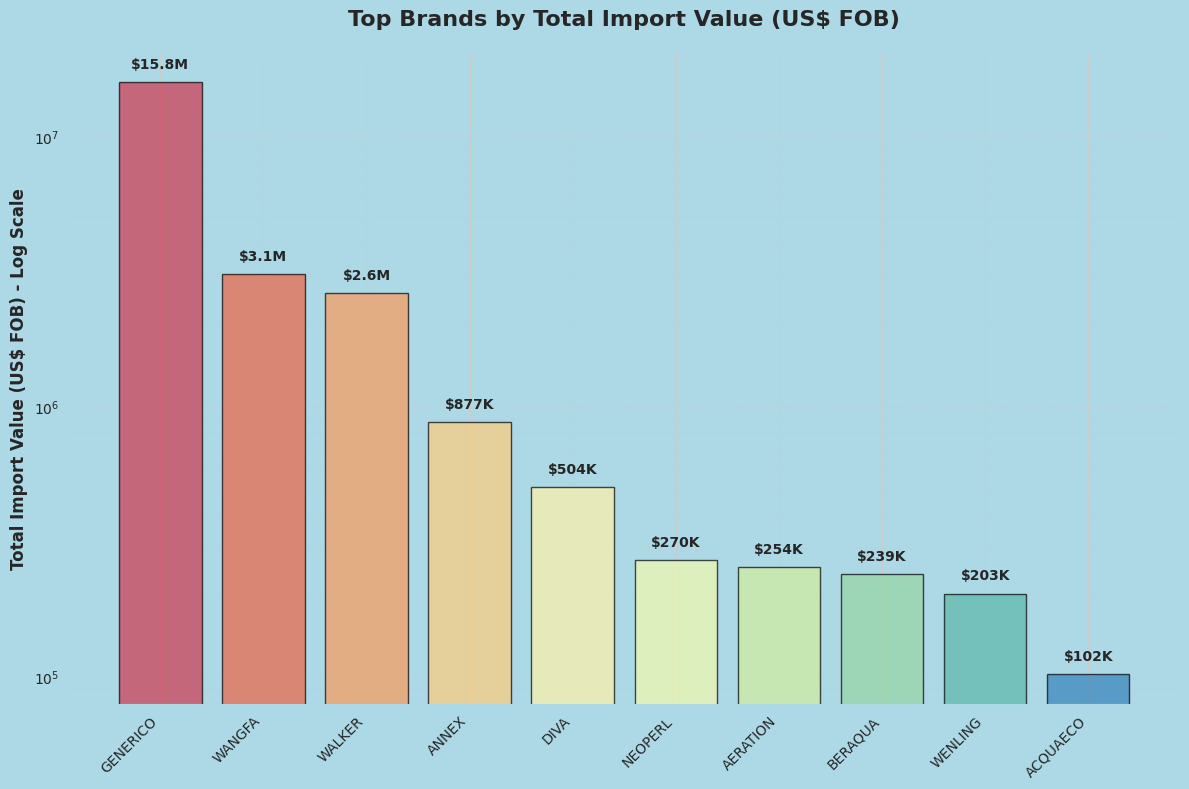

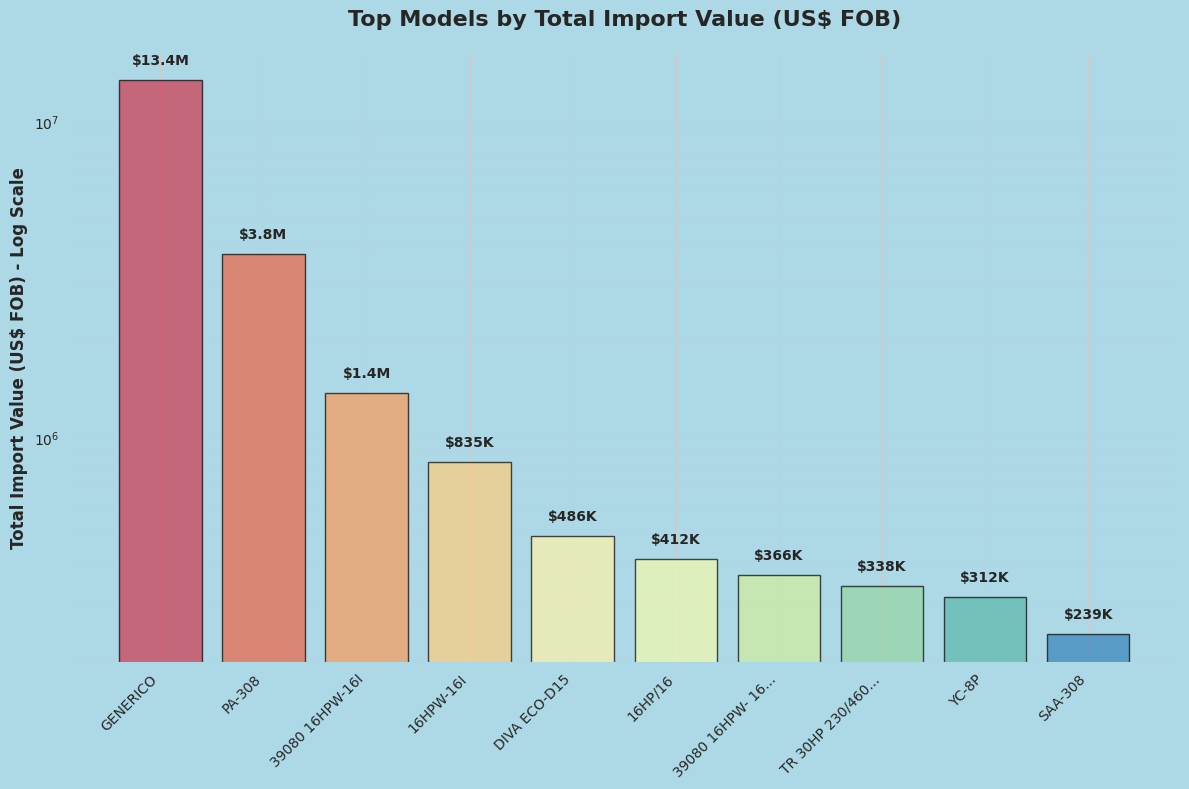

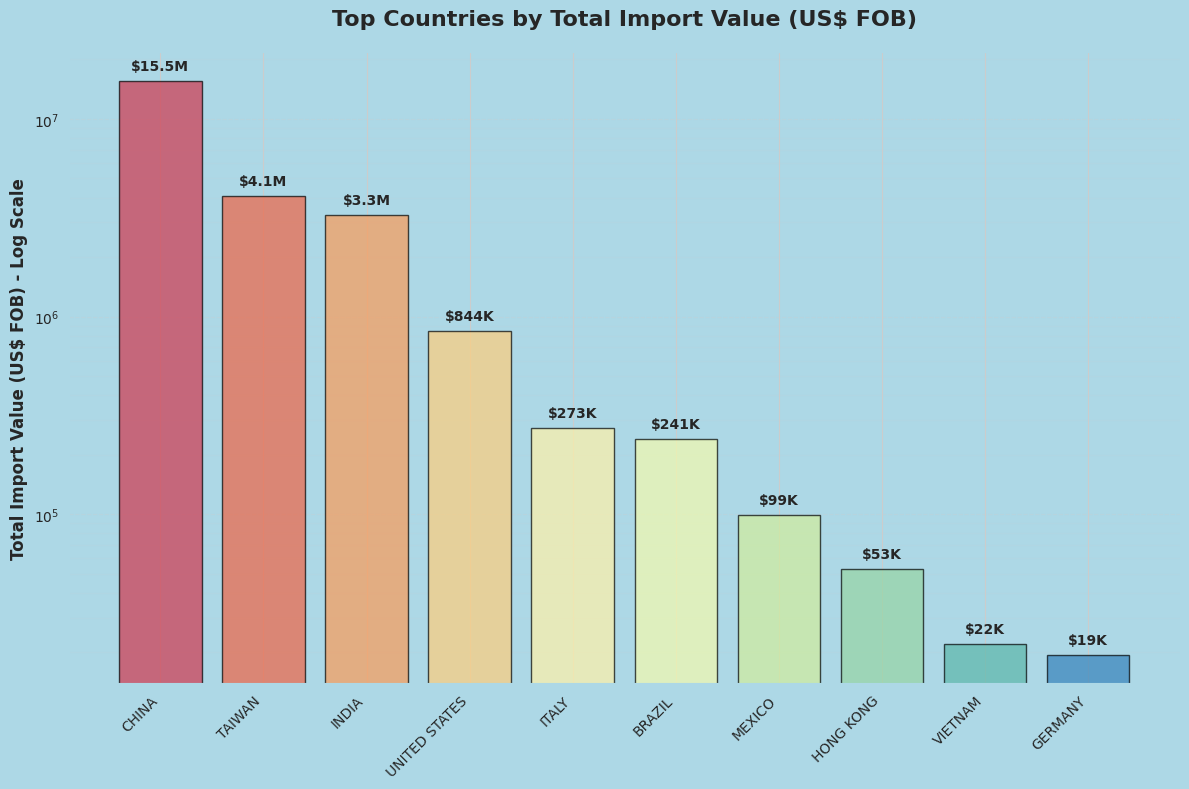

✅ Created 3 categorical analysis plots


In [2]:
# Step 5: Create categorical analysis plots
categorical_figs = processor.visualizer.create_categorical_analysis_plots(
    cleaned_data
)


### Step 5c: Create Price Distribution Plot

Generate price distribution analysis plot separately.


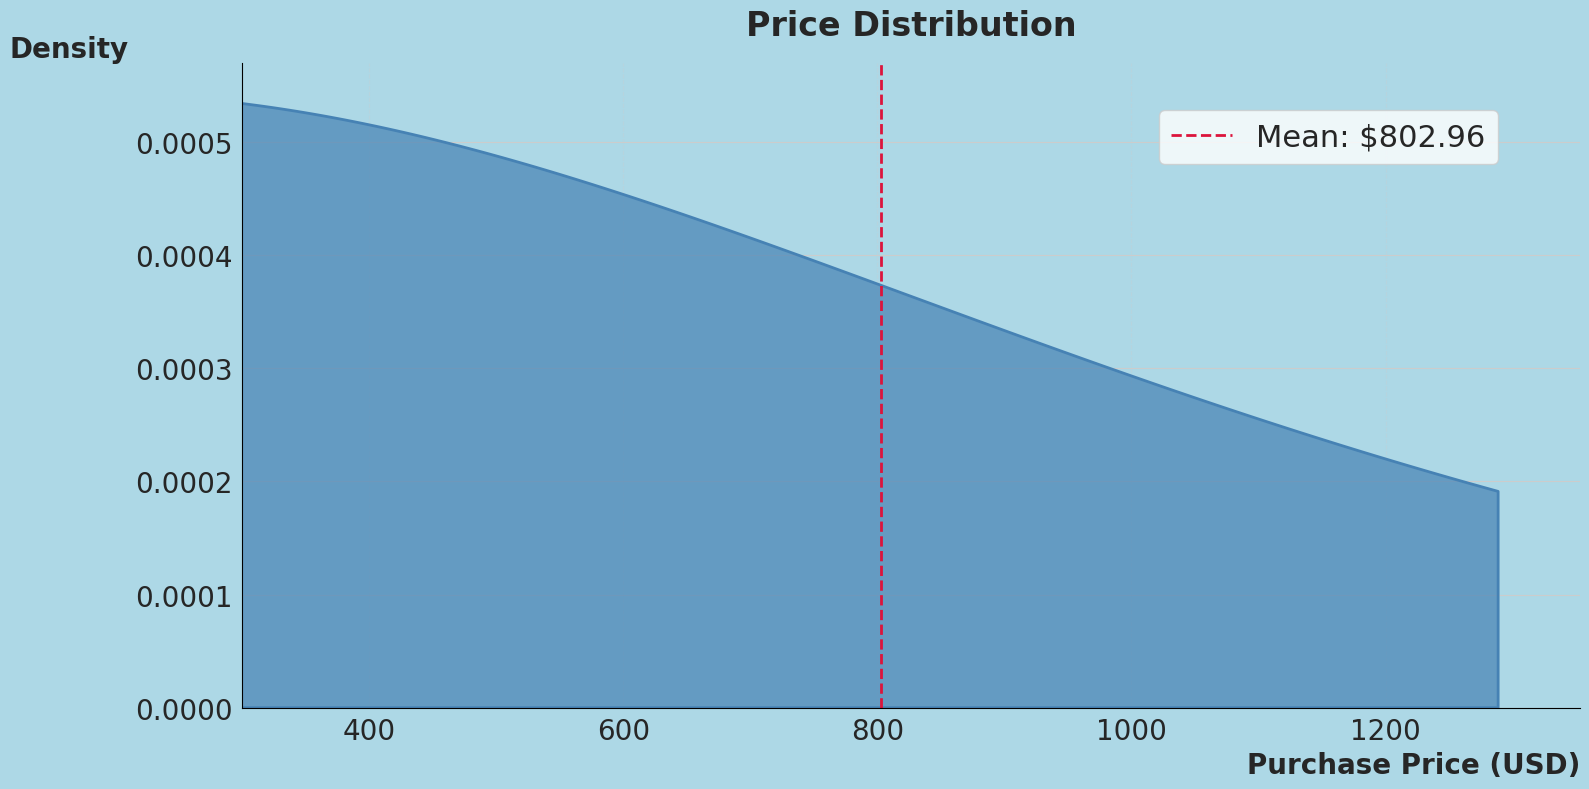

In [3]:
# Step 5c: Create price distribution plot
price_dist_fig = processor.visualizer.create_price_distribution_plot(
    cleaned_data
)


### Step 5d: Create Brand Price Comparison Plot

Generate brand price comparison analysis plot separately.


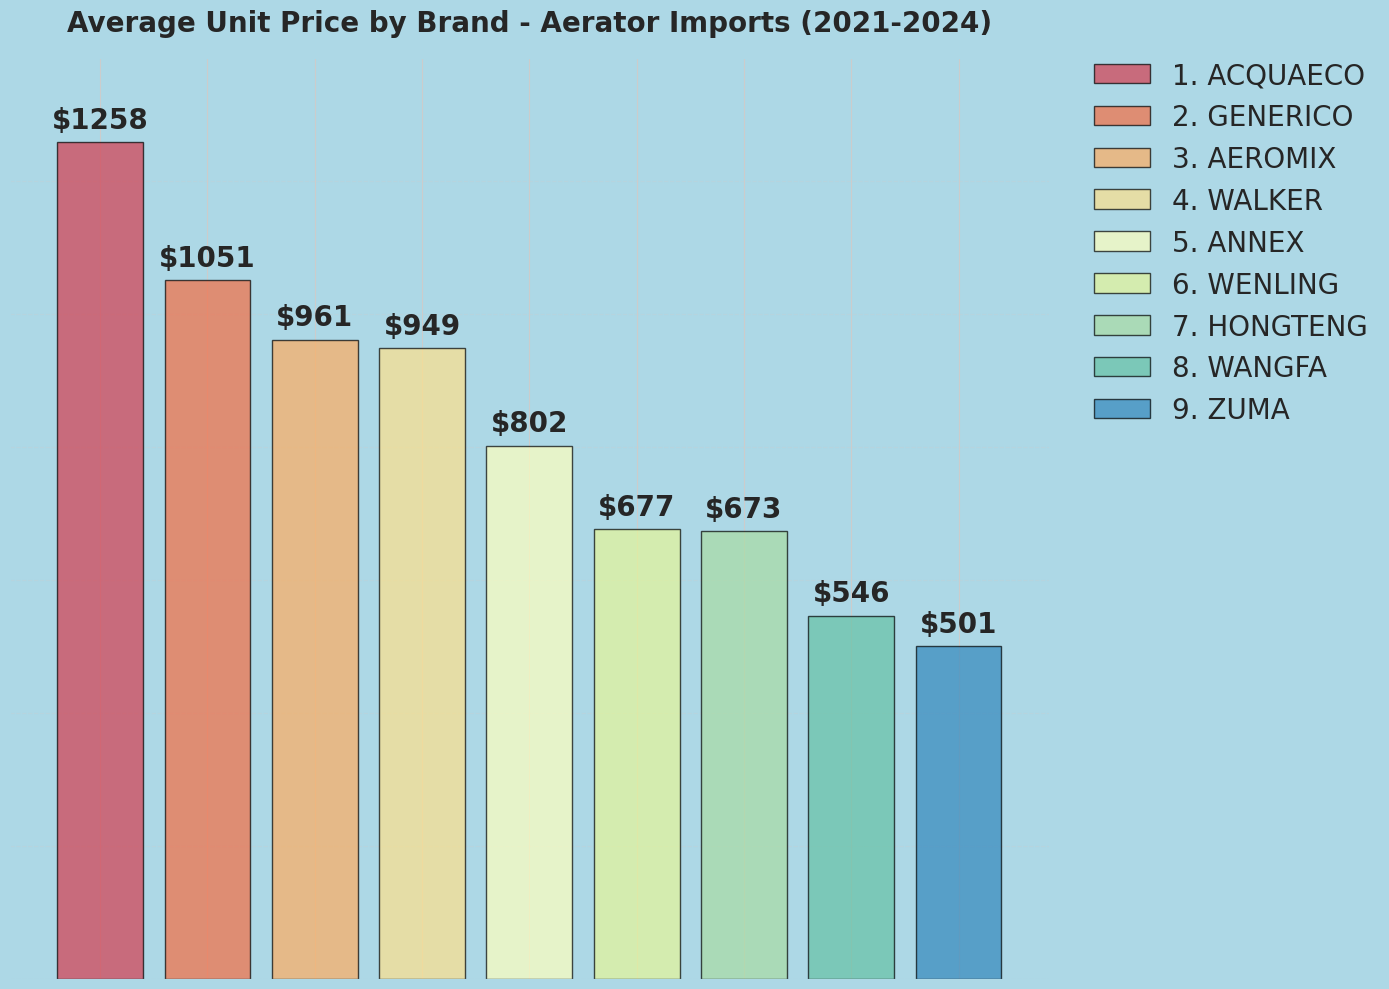

In [4]:
# Step 5d: Create brand price comparison plot
brand_price_fig = processor.visualizer.create_brand_price_comparison_plot(
    cleaned_data
)
